In [1]:
import pandas as pd
import numpy as np
import os
import sumolib
import random
from tqdm import tqdm
from datetime import datetime

# 1. 이동류 매칭

In [2]:
# [이동류번호] 불러오기 (약 1분의 소요시간)
path_moves = '../../Data/tables/moves/'
csv_moves = os.listdir('../../Data/tables/moves/')
moves = [pd.read_csv(path_moves + csv_move, index_col=0) for csv_move in tqdm(csv_moves)]
match1 = pd.concat(moves).drop_duplicates().sort_values(by=['inter_no','phas_A','phas_B']).reset_index(drop=True)
match1.head(10)

100%|██████████| 17280/17280 [01:21<00:00, 211.23it/s]


inter_no  phas_A  phas_B  move_A  move_B
0       175       1       1       8       4
1       175       2       2       7       3
2       175       3       3       6       1
3       175       3       4       6       2
4       175       4       4       5       2
5       176       1       1       8       4
6       176       2       2       8       3
7       176       3       3       5      18
8       177       1       1       8       4
9       177       2       2       7       3

In [3]:
# 계층화 (inter_no, phas_A, phas_B, move_A, move_B) -> ('inter_no', 'phase_no', 'ring_type', 'move_no')
matchA = match1[['inter_no', 'phas_A', 'move_A']].copy()
matchA.columns = ['inter_no', 'phase_no', 'move_no']
matchA['ring_type'] = 'A'
matchB = match1[['inter_no', 'phas_B', 'move_B']].copy()
matchB.columns = ['inter_no', 'phase_no', 'move_no']
matchB['ring_type'] = 'B'
match2 = pd.concat([matchA, matchB]).drop_duplicates()
match2 = match2[['inter_no', 'phase_no', 'ring_type', 'move_no']]
match2 = match2.sort_values(by=list(match2.columns))
match2.head(10)

inter_no  phase_no ring_type  move_no
0       175         1         A        8
0       175         1         B        4
1       175         2         A        7
1       175         2         B        3
2       175         3         A        6
2       175         3         B        1
4       175         4         A        5
3       175         4         B        2
5       176         1         A        8
5       176         1         B        4

In [4]:
# [nema 이동류목록] 불러오기 및 병합
nema = pd.read_csv('../../Data/tables/nema.csv', encoding='cp949')
match3 = pd.merge(match2, nema, how='left', left_on='move_no', right_on='이동류번호').drop_duplicates()
match3.rename(columns={'진입방향': 'inc_dir', '진출방향': 'out_dir'}, inplace=True)
match3.drop('이동류번호', axis=1, inplace=True)
match3

inter_no  phase_no ring_type  move_no inc_dir out_dir
0        175         1         A        8       남       북
1        175         1         B        4       북       남
2        175         2         A        7       북       동
3        175         2         B        3       남       서
4        175         3         A        6       동       서
..       ...       ...       ...      ...     ...     ...
59       210         4         B        3       남       서
60       211         1         A        6       동       서
61       211         1         B        2       서       동
62       211         2         A       17     NaN     NaN
63       211         2         B       18     NaN     NaN

[64 rows x 6 columns]

In [5]:
# [방위각정보] 불러오기, 계층화, 병합
# 불러오기
dtype_dict = {f'angle_{alph}{j}':'str' for alph in ['A', 'B'] for j in range(1,9)}
angle_original = pd.read_csv('../../Data/tables/angle.csv', index_col=0, dtype = dtype_dict)
# 계층화
angle = []
for i, row in angle_original.iterrows():
    angle_codes = row[[f'angle_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
    new = pd.DataFrame({'inter_no':[row.inter_no] * 16, 'phase_no':list(range(1, 9))*2, 'ring_type':['A'] * 8 + ['B'] * 8, 'angle_code':angle_codes.to_list()})
    angle.append(new)
angle = pd.concat(angle)
angle = angle.dropna().reset_index(drop=True)
# 병합
six_chars = angle.angle_code.apply(lambda x:len(x)==6)
angle.loc[six_chars,'inc_angle'] = angle.angle_code.apply(lambda x:x[:3])
angle.loc[six_chars,'out_angle'] = angle.angle_code.apply(lambda x:x[3:])
angle = angle.drop('angle_code', axis=1)
match4 = pd.merge(match3, angle, how='left', left_on=['inter_no', 'phase_no', 'ring_type'],
                 right_on=['inter_no', 'phase_no', 'ring_type']).drop_duplicates()
match4

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle
0        175         1         A        8       남       북       179       004
1        175         1         B        4       북       남       003       176
2        175         2         A        7       북       동       001       095
3        175         2         B        3       남       서       179       270
4        175         3         A        6       동       서       090       270
..       ...       ...       ...      ...     ...     ...       ...       ...
59       210         4         B        3       남       서       180       270
60       211         1         A        6       동       서       090       270
61       211         1         B        2       서       동       270       090
62       211         2         A       17     NaN     NaN       NaN       NaN
63       211         2         B       18     NaN     NaN       NaN       NaN

[64 rows x 8 columns]

In [150]:
# [네트워크], [교차로-노드 매칭], [교차로정보] 불러오기 
net = sumolib.net.readNet('../../Data/networks/SN_sample.net.xml')
inter_node = pd.read_csv('../../Data/tables/inter_node.csv', index_col=0)
inter_info = pd.read_csv('../../Data/tables/inter_info.csv', index_col=0)

inter_node1 = inter_node[inter_node.inter_type == 'parent'].drop('inter_type', axis=1)
inter_info1 = inter_info[['inter_no', 'inter_lat', 'inter_lon']]
inter = pd.merge(inter_node1, inter_info1, how='left', left_on=['inter_no'],
                 right_on=['inter_no']).drop_duplicates()

inter2node = dict(zip(inter['inter_no'], inter['node_id']))

match5 = match4.copy()
# 진입진출ID 매칭
for index, row in match5.iterrows():
    node_id = inter2node[row.inter_no]
    node = net.getNode(node_id)
    # 교차로의 모든 (from / to) edges
    inc_edges = [edge for edge in node.getIncoming() if edge.getFunction() == ''] # incoming edges
    out_edges = [edge for edge in node.getOutgoing() if edge.getFunction() == ''] # outgoing edges
    # 교차로의 모든 (from / to) directions
    inc_dirs = []
    for inc_edge in inc_edges:
        start = inc_edge.getShape()[-2]
        end = inc_edge.getShape()[-1]
        inc_dir = np.array(end) - np.array(start)
        inc_dir = inc_dir / (inc_dir ** 2).sum() ** 0.5
        inc_dirs.append(inc_dir)
    out_dirs = []
    for out_edge in out_edges:
        start = out_edge.getShape()[0]
        end = out_edge.getShape()[1]
        out_dir = np.array(end) - np.array(start)
        out_dir = out_dir / (out_dir ** 2).sum() ** 0.5
        out_dirs.append(out_dir)
    # 진입각, 진출각 불러오기
    if not pd.isna(row.inc_angle):
        inc_angle = int(row.inc_angle)
        out_angle = int(row.out_angle)
        # 방위각을 일반각으로 가공, 라디안 변환, 단위벡터로 변환
        inc_angle = (-90 - inc_angle) % 360
        inc_angle = inc_angle * np.pi / 180.
        inc_dir_true = np.array([np.cos(inc_angle), np.sin(inc_angle)])
        out_angle = (90 - out_angle) % 360
        out_angle = out_angle * np.pi / 180.
        out_dir_true = np.array([np.cos(out_angle), np.sin(out_angle)])
        # 매칭 엣지 반환
        inc_index = np.array([np.dot(inc_dir, inc_dir_true) for inc_dir in inc_dirs]).argmax()
        out_index = np.array([np.dot(out_dir, out_dir_true) for out_dir in out_dirs]).argmax()
        inc_edge_id = inc_edges[inc_index].getID()
        out_edge_id   = out_edges[out_index].getID()
        match5.at[index, 'inc_edge'] = inc_edge_id
        match5.at[index, 'out_edge'] = out_edge_id
match5['node_id'] = match5['inter_no'].map(inter2node)
match5 = match5[['inter_no', 'node_id', 'move_no', 'inc_edge', 'out_edge']]
match5 = match5.sort_values(by=['inter_no', 'move_no']).reset_index(drop=True)

In [152]:
matching = match5.drop_duplicates().copy()
matching.head(10)

inter_no node_id  move_no         inc_edge      out_edge
0       175      i0        1     571545870_02  571542797_02
1       175      i0        2     571510153_02  571545870_01
2       175      i0        3    -571542797_02  571510153_01
3       175      i0        4    -571500487_01  571542797_02
4       175      i0        5     571510153_02  571500487_01
5       175      i0        6     571545870_02  571510153_01
6       175      i0        7    -571500487_01  571545870_01
7       175      i0        8    -571542797_02  571500487_01
8       176      i1        3    -571542810_01  571543469_01
9       176      i1        4  571542797_02.99  571542810_01

# 2. 이력 + 이동류

In [ ]:
# 5초 단위로 이동류번호 저장 및 신호이력에서 유닉스시각 가져와서 표시, 한시간동안의 데이터만 보관
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fsecs = range(midnight, next_day, 5) # fsecs : unix time by Five SECondS
time2move = dict(zip(fsecs,moves)) # move : 어느 순간의 이동류정보
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)

time2movement = {} # movement : 어느 순간의, 그 순간으로부터 한시간 동안의 (교차로번호 + 현시별이동류번호 + 시작시간)
# - 아래 절차를 5초마다 반복
for fsec in tqdm(fsecs): # fsec : unix time by Five SECond
    # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
    move = time2move[fsec]
    # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로변호, 종료유닉스타임)만 수집 : B
    recent_histories = [group.iloc[-1:] for _, group in history[history['end_unix'] < fsec].groupby('inter_no')] # 교차로별로 유닉스시간이 최대인 행들
    if not recent_histories:
        rhistory = pd.DataFrame({'inter_no':[], 'end_unix':[]}) # recent history
    else:
        rhistory = pd.concat(recent_histories)
    recent_unix = rhistory[['inter_no', 'end_unix']]
    # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
    move = pd.merge(move, recent_unix, how='left', on='inter_no')
    move['end_unix'] = move['end_unix'].fillna(0).astype(int)
    move = move.drop_duplicates()
    # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
    move = move.rename(columns = {'end_unix':'start_unix'})
    # 5. 이동류 이력정보 READ
    #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
    try:
        if isinstance(movement, pd.DataFrame): # movement가 존재할 경우 그걸 그대로 씀.
            pass
        else: 
            movement = pd.DataFrame()
    except NameError: # movement가 존재하지 않는 경우 생성
        movement = pd.DataFrame()
    # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
    movement = pd.concat([movement, move])
    # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
    movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
    # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - 3600을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
    movement = movement[movement.start_unix > fsec - 3600]
    # print()
    # print(fsec)
    # print(fsec - 3600)
    start_unix_min = movement.start_unix.min()
    start_unix_max = movement.start_unix.max()
    # print(start_unix_min)
    # print(start_unix_max)
    # print(start_unix_max - start_unix_min)
    movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)

    time2movement[fsec] = movement
    movement.to_csv(f'../../Data/tables/movements/movements_{fsec}.csv')
# del movement

In [15]:
# movement : 5초단위로 과거 한시간 동안의 이동류번호 (교차로번호, 시작유닉스, A현시번호, B현시번호, A이동류, B이동류)
# 한시간짜리 맞음.
n = 15000 # ranges from 0 to 17280 = len(fsecs)
print(midnight)
print(next_day)
start_unix_min = time2movement[fsecs[n]].start_unix.min()
start_unix_max = time2movement[fsecs[n]].start_unix.max()
print(start_unix_min)
print(start_unix_max)
print(start_unix_max - start_unix_min)

1704380400
1704466800
1704451815
1704455390
3575


In [16]:
import matplotlib.pyplot as plt
plt.plot(fsecs, [len(time2movement[fsec]) for fsec in fsecs])
plt.close()

In [72]:
# 세부현시로 되어있던 history를 A, B로 나뉘어 현시시간이 구성된 형태로 바꿈.
plan = pd.read_csv('../../Data/tables/plan.csv', index_col=0)
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)
splits = {} # splits maps (inter_no, start_hour, start_minute) to split
for i, row in plan.iterrows():
    inter_no = row.inter_no
    start_hour = row.start_hour
    start_minute = row.start_minute
    cycle = row.cycle
    cums_A = row[[f'dura_A{j}' for j in range(1,9)]].cumsum()
    cums_B = row[[f'dura_B{j}' for j in range(1,9)]].cumsum()
    splits[(inter_no, start_hour, start_minute)] = {} # split maps (phas_A, phas_B) to k
    k = 0
    for t in range(cycle):
        new_phas_A = len(cums_A[cums_A < t]) + 1
        new_phas_B = len(cums_B[cums_B < t]) + 1
        if k == 0 or ((new_phas_A, new_phas_B) != (phas_A, phas_B)):
            k += 1
        phas_A = new_phas_A
        phas_B = new_phas_B
        splits[(inter_no, start_hour, start_minute)][(phas_A, phas_B)] = k
# the inverse of splits
isplits = {} # isplit maps k to (phas_A, phas_B)
for i in splits:
    isplits[i] = {splits[i][k]:k for k in splits[i]}

timetable = plan[['start_hour', 'start_minute']].drop_duplicates()
timetable['start_seconds'] = midnight + timetable['start_hour'] * 3600 + timetable['start_minute'] * 60

abhistory = history.copy() # A, B가 나뉘어진 history
# history의 행들을 순회하며 새로운 열 dur_A1, dur_A2, ... 를 만들어내고 값을 배정함.
for i, row in abhistory.iterrows():
    inter_no = row.inter_no
    ind = (timetable['start_seconds'] < row.end_unix).sum() - 1
    start_hour = timetable.iloc[ind].start_hour
    start_minute = timetable.iloc[ind].start_minute
    isplit = isplits[(inter_no,start_hour,start_minute)]
    dur_dict = {}
    dur_chars = [f'dur_{alph}{j}' for alph in ['A', 'B'] for j in range(1, 9)] # 새로운 행들
    for dur_char in dur_chars:
        dur_dict[dur_char] = 0
    for k in range(1, len(isplit)+1): # dur_dict에 값 저장
        ja = isplit[k][0] # A현시번호
        jb = isplit[k][1] # B현시번호
        dur_dict[f'dur_A{ja}'] += row[f'ddur_{k}']
        dur_dict[f'dur_B{jb}'] += row[f'ddur_{k}']
    for dur_char in dur_chars: # history의 새로운 열들에 값 배정
        abhistory.at[i, dur_char] = dur_dict[dur_char]
abhistory = abhistory[['inter_no','end_unix'] + dur_chars + ['cycle']].astype(int)
abhistory = abhistory.astype(int).sort_values(by = ['end_unix','inter_no'])
abhistory.head()

inter_no    end_unix  dur_A1  dur_A2  dur_A3  dur_A4  dur_A5  dur_A6  \
0       206  1704380521      33      35      26      26       0       0   
1       211  1704380526      28      97       0       0       0       0   
2       178  1704380540      38      39      40      23       0       0   
3       201  1704380540      24      24      17      58      17       0   
4       202  1704380540      39     101       0       0       0       0   

   dur_A7  dur_A8  dur_B1  dur_B2  dur_B3  dur_B4  dur_B5  dur_B6  dur_B7  \
0       0       0      33      35      26      26       0       0       0   
1       0       0      28      97       0       0       0       0       0   
2       0       0      38      39      40      23       0       0       0   
3       0       0      24      24      17      58      17       0       0   
4       0       0      39     101       0       0       0       0       0   

   dur_B8  cycle  
0       0    120  
1       0    125  
2       0    140  
3       0    140  
4       0    140

In [73]:
history

inter_no    end_unix  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  \
0          206  1704380521      33      35      26      26       0       0   
1          211  1704380526      28      97       0       0       0       0   
2          178  1704380540      38      39      40      23       0       0   
3          201  1704380540      24      24      17      58      17       0   
4          202  1704380540      39     101       0       0       0       0   
...        ...         ...     ...     ...     ...     ...     ...     ...   
4684       178  1704466729      38      39      44      36      23       0   
4685       202  1704466740      48     122       0       0       0       0   
4686       206  1704466740      46      62      26      26       0       0   
4687       175  1704466740      46      48      37      18      41       0   
4688       211  1704466795      28     117       0       0       0       0   

      ddur_7  ddur_8  cycle  offset  
0          0       0    120      10  
1          0       0    125      45  
2          0       0    140      50  
3          0       0    140     133  
4          0       0    140     103  
...      ...     ...    ...     ...  
4684       0       0    180      75  
4685       0       0    170     103  
4686       0       0    160      10  
4687       0       0    190      18  
4688       0       0    145      55  

[4689 rows x 12 columns]

In [275]:
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
present_time = fmins[60] ####### 현재 시점 ranges from 0 to 288

In [276]:
# - 5분마다 신호이력 데이터 수집해서 통합테이블 생성할때
# moves_fmins = [pd.read_csv(path_moves + csv_move, index_col=0) for csv_move in csv_moves if int(csv_move[5:-4]) in fmins]
# fmin2move = dict(zip(fmins,moves_fmins))
print(present_time)
# 1. 조회시점의 유닉스 타임을 기준으로 신호이력의 유닉스 타임이 1시간(또는 2시간) 이내인 데이터 수집
rhistory = history.copy()
rhistory = rhistory[(rhistory.end_unix < present_time) & (rhistory.end_unix >= present_time - 3600)]
# durs_A = [f'dur_A{j}' for j in range(1, 9)]
# durs_B = [f'dur_B{j}' for j in range(1, 9)]
ddurs = [f'ddur_{j}' for j in range(1, 9)]

# 2. 시작 유닉스 타임컬럼 생성 후 종류 유닉스 타임에서 현시별 현시기간 컬럼의 합을 뺀 값으로 입력
# - 현시시간의 합을 뺀 시간의 +- 10초 이내에 이전 주기정보가 존재하면 그 유닉스 시간을 시작 유닉스시간 값으로 하고, 존재하지 않으면 현시시간의 합을 뺀 유닉스 시간을 시작 유닉스 시간으로 지정
# # 이전 유닉스 존재하지 않음 => 현시시간 합의 차
# # 이전 유닉스 존재, abs < 10 => 이전 유닉스
# # 이전 유닉스 존재, abs >=10 => 현시시간 합의 차
for i, row in rhistory.iterrows():
    inter_no = row.inter_no
    end_unix = row.end_unix
    elapsed_time = row[ddurs].sum()
    start_unix = end_unix - elapsed_time
    pre_rows = history[:i] # previous rows
    if inter_no in pre_rows.inter_no.unique(): # 이전 유닉스 존재
        pre_unix = pre_rows[pre_rows.inter_no == inter_no]['end_unix'].iloc[-1] # previous unix time
        if abs(pre_unix - start_unix) < 10: # abs < 10
            start_unix = pre_unix
        else: # abs >= 10
            pass
    rhistory.loc[i, 'start_unix'] = start_unix
rhistory[rhistory.isna()] = 0
rhistory['start_unix'] = rhistory['start_unix'].astype(int)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(rhistory)
rhistory = rhistory[['inter_no', 'start_unix'] + ddurs + ['cycle']]
rhistory

1704398400


inter_no  start_unix  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  \
918        210  1704394650      24      19      29      56      22       0   
919        176  1704394650      37      73      40       0       0       0   
920        175  1704394640      37      39      25      30      29       0   
921        177  1704394650      36      20      68      26       0       0   
922        206  1704394680      33      35      26      26       0       0   
...        ...         ...     ...     ...     ...     ...     ...     ...   
1146       211  1704398175      28      97       0       0       0       0   
1147       202  1704398180      39     101       0       0       0       0   
1148       175  1704398160      37      39      25      30      29       0   
1149       201  1704398180      24      24      17      58      17       0   
1150       178  1704398180      38      39      40      23       0       0   

      ddur_7  ddur_8  cycle  
918        0       0    150  
919        0       0    150  
920        0       0    160  
921        0       0    150  
922        0       0    120  
...      ...     ...    ...  
1146       0       0    125  
1147       0       0    140  
1148       0       0    160  
1149       0       0    140  
1150       0       0    140  

[233 rows x 11 columns]

In [277]:
# 계층화된 형태로 변환
hrhistory = [] # hierarchied recent history
for i, row in rhistory.iterrows():
    inter_no = row.inter_no #
    start_unix = row.start_unix #
    ind = (timetable['start_seconds'] < row.start_unix).sum() - 1
    start_hour = timetable.iloc[ind].start_hour
    start_minute = timetable.iloc[ind].start_minute
    isplit = isplits[(inter_no, start_hour, start_minute)]
    new_rows = []
    for j in isplit.keys():
        phas_A, phas_B = isplit[j]
        duration = row[f'ddur_{j}']
        new_rows.append(pd.DataFrame({'inter_no':[inter_no], 'start_unix':[start_unix],
                                    'phas_A':[phas_A],'phas_B':[phas_B],'duration':[duration]}))
    new_rows = pd.concat(new_rows)
    hrhistory.append(new_rows)
hrhistory = pd.concat(hrhistory)
hrhistory = hrhistory.sort_values(by = ['start_unix', 'inter_no', 'phas_A', 'phas_B']).reset_index(drop=True)
display(hrhistory)

inter_no  start_unix  phas_A  phas_B  duration
0         175  1704394640       1       1        37
1         175  1704394640       2       2        39
2         175  1704394640       3       3        25
3         175  1704394640       3       4        30
4         175  1704394640       4       4        29
..        ...         ...     ...     ...       ...
864       201  1704398180       3       3        17
865       201  1704398180       4       4        58
866       201  1704398180       5       5        17
867       202  1704398180       1       1        39
868       202  1704398180       2       2       101

[869 rows x 5 columns]

In [278]:
# 5초단위로 수집한 이동류정보(time2movement[present_time])와 최근 1시간 신호이력(hrhistory)을 병합
movedur = pd.merge(time2movement[present_time], hrhistory, how='inner', on=['inter_no', 'start_unix', 'phas_A', 'phas_B'])
# movements and durations
movedur = movedur.sort_values(by=['start_unix', 'inter_no', 'phas_A','phas_B'])
movedur = movedur[['inter_no', 'start_unix', 'phas_A', 'phas_B', 'move_A', 'move_B', 'duration']]
# 이동류 매칭 테이블에서 진입id, 진출id를 가져와서 붙임.
for i, row in movedur.iterrows():
    inter_no = row.inter_no
    start_unix = row.start_unix
    move_A = row.move_A
    move_B = row.move_B
    match_A = matching[(matching.inter_no == inter_no) & (matching.move_no == move_A)].iloc[0]
    match_B = matching[(matching.inter_no == inter_no) & (matching.move_no == move_B)].iloc[0]
    inc_edge_A = match_A.inc_edge
    inc_edge_B = match_B.inc_edge
    out_edge_A = match_A.out_edge
    out_edge_B = match_B.out_edge
    movedur.loc[i, ['inc_edge_A', 'inc_edge_B', 'out_edge_A', 'out_edge_B']] = [inc_edge_A, inc_edge_B, out_edge_A, out_edge_B]
# 이동류 컬럼 제거
movedur = movedur.drop(['move_A', 'move_B'], axis=1)
movedur

inter_no  start_unix  phas_A  phas_B  duration       inc_edge_A  \
0         211  1704394815       1       1        28     571542116_01   
1         211  1704394815       2       2        97              NaN   
2         178  1704394820       1       1        38     571540304_02   
3         178  1704394820       2       2        39     571556450_02   
4         178  1704394820       3       3        40  571540303_02.21   
..        ...         ...     ...     ...       ...              ...   
809       201  1704398180       3       3        17     571500617_02   
810       201  1704398180       4       4        58     571500617_02   
811       201  1704398180       5       5        17     571500583_01   
812       202  1704398180       1       1        39     571510152_02   
813       202  1704398180       2       2       101              NaN   

          inc_edge_B        out_edge_A        out_edge_B  
0    571542116_02.96  -571542116_02.96  571542116_02.164  
1                NaN               NaN               NaN  
2       571556450_02      571556450_01      571540304_01  
3       571540304_02      571500475_01      571540303_01  
4    571540303_02.21      571556450_01      571500475_01  
..               ...               ...               ...  
809     571500618_02      571500618_01      571500617_01  
810     571500617_02      571500618_01      571500569_01  
811     571500583_01      571500617_01      571500569_01  
812     571510152_01     -571510152_01   571510152_01.65  
813              NaN               NaN               NaN  

[814 rows x 9 columns]

In [279]:
histid = movedur.copy() # history with edge ids (incoming and outgoing edge ids)
# print(present_time)
# print(histid.start_unix.min())
# print(histid.start_unix.max())
# print(histid.start_unix.max() - histid.start_unix.min())
plt.figure(figsize=(10, 6))
times = [histid.start_unix.min(), histid.start_unix.max(), present_time]
ys = [0] * 3
plt.scatter(times, ys)
plt.close()

In [280]:
histid.inter_no.unique()

array([211, 178, 201, 202, 206, 177, 176, 210, 175], dtype=int64)

# 3. 결측, 이상치 처리

In [235]:
planned = plan.copy()
planned['start_unix'] = planned['start_hour'] * 3600 +planned['start_minute'] * 60 + midnight
start_unixes = planned.start_unix.unique()
planned['pstart_unix'] = planned['start_unix'].apply(lambda x:start_unixes[sum(start_unixes <= x) - 1]) # the unix time when the program started
planned = planned[['inter_no', 'start_unix'] + [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)] + ['cycle', 'pstart_unix']]
planned.head(10)

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  dura_A6  \
0       175  1704380400       37       39       55       29        0        0   
1       175  1704405600       40       42       55       33        0        0   
2       175  1704412800       43       45       55       37        0        0   
3       175  1704447000       46       48       55       41        0        0   
4       176  1704380400       37       73       40        0        0        0   
5       176  1704405600       37       93       40        0        0        0   
6       176  1704412800       37      103       40        0        0        0   
7       176  1704447000       37      113       40        0        0        0   
8       177  1704380400       36       20       68       26        0        0   
9       177  1704405600       40       25       71       34        0        0   

   dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  dura_B6  \
0        0        0       37       39       25       59        0        0   
1        0        0       40       42       29       59        0        0   
2        0        0       43       45       33       59        0        0   
3        0        0       46       48       37       59        0        0   
4        0        0       37       73       40        0        0        0   
5        0        0       37       93       40        0        0        0   
6        0        0       37      103       40        0        0        0   
7        0        0       37      113       40        0        0        0   
8        0        0       36       20       68       26        0        0   
9        0        0       40       25       71       34        0        0   

   dura_B7  dura_B8  cycle  pstart_unix  
0        0        0    160   1704380400  
1        0        0    170   1704405600  
2        0        0    180   1704412800  
3        0        0    190   1704447000  
4        0        0    150   1704380400  
5        0        0    170   1704405600  
6        0        0    180   1704412800  
7        0        0    190   1704447000  
8        0        0    150   1704380400  
9        0        0    170   1704405600

In [236]:
histid = movedur.copy() # history with edge ids (incoming and outgoing edge ids)
histid

inter_no  start_unix  phas_A  phas_B  duration       inc_edge_A  \
0         211  1704394815       1       1        28     571542116_01   
1         211  1704394815       2       2        97              NaN   
2         178  1704394820       1       1        38     571540304_02   
3         178  1704394820       2       2        39     571556450_02   
4         178  1704394820       3       3        40  571540303_02.21   
..        ...         ...     ...     ...       ...              ...   
809       201  1704398180       3       3        17     571500617_02   
810       201  1704398180       4       4        58     571500617_02   
811       201  1704398180       5       5        17     571500583_01   
812       202  1704398180       1       1        39     571510152_02   
813       202  1704398180       2       2       101              NaN   

          inc_edge_B        out_edge_A        out_edge_B  
0    571542116_02.96  -571542116_02.96  571542116_02.164  
1                NaN               NaN               NaN  
2       571556450_02      571556450_01      571540304_01  
3       571540304_02      571500475_01      571540303_01  
4    571540303_02.21      571556450_01      571500475_01  
..               ...               ...               ...  
809     571500618_02      571500618_01      571500617_01  
810     571500617_02      571500618_01      571500569_01  
811     571500583_01      571500617_01      571500569_01  
812     571510152_01     -571510152_01   571510152_01.65  
813              NaN               NaN               NaN  

[814 rows x 9 columns]

In [270]:
histid.inter_no.unique()

array([211, 178, 201, 202, 206, 177, 176, 210, 175], dtype=int64)

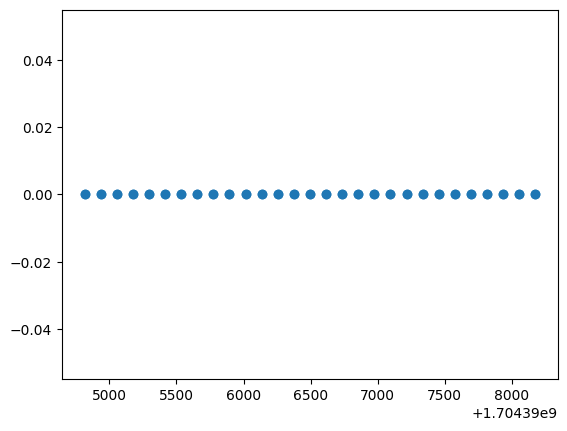

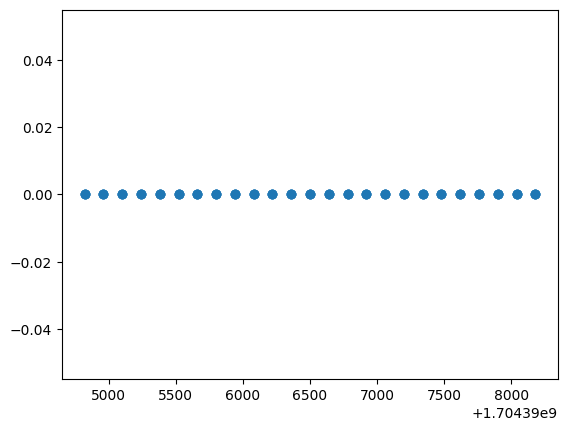

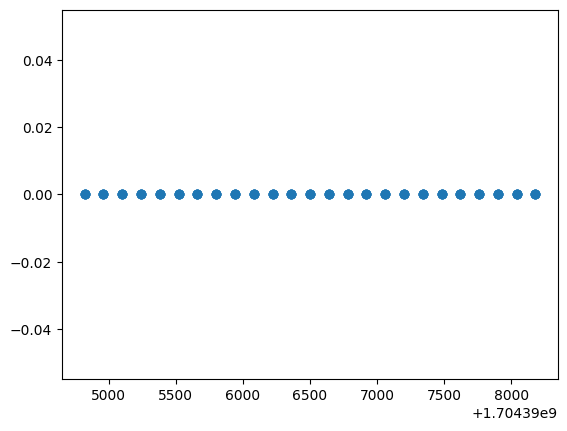

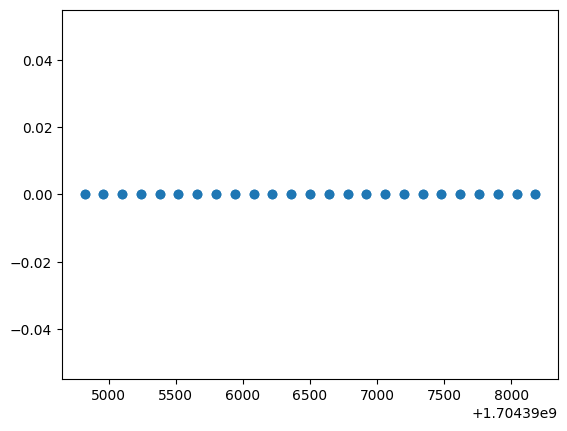

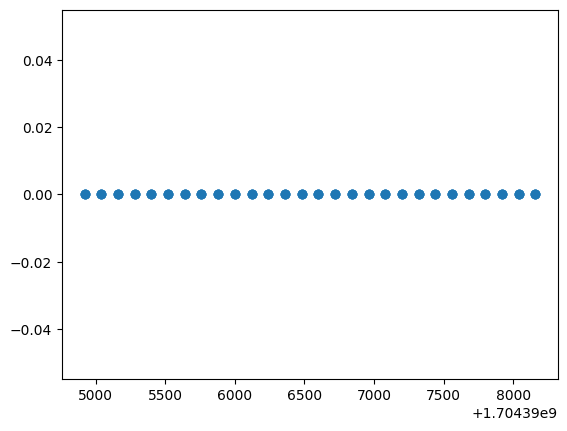

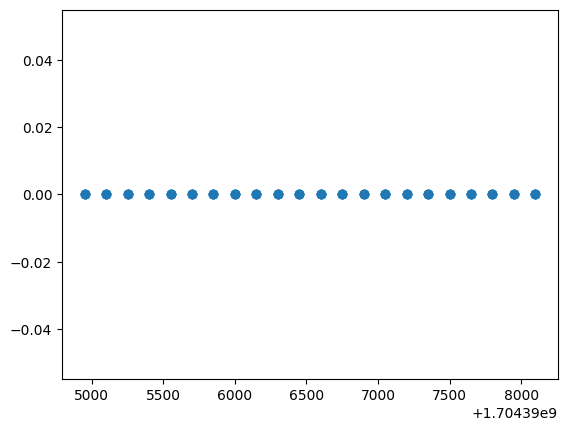

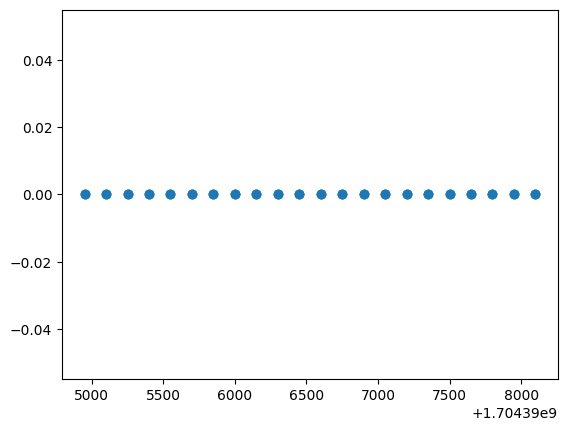

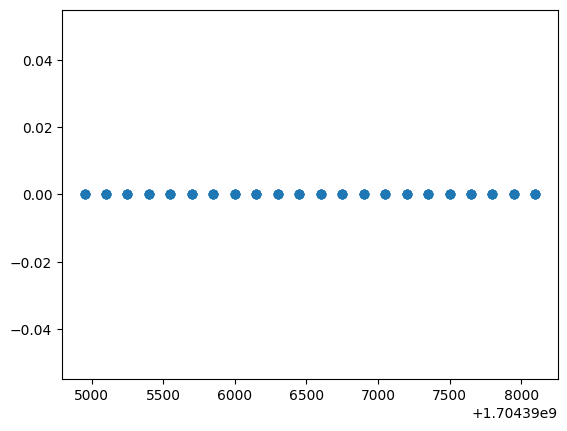

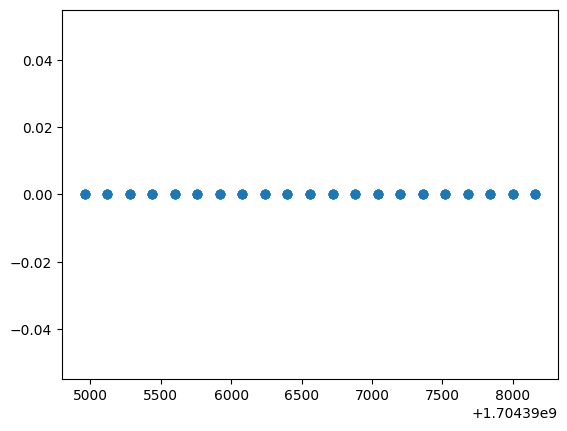

In [272]:
for inter_no in histid.inter_no.unique():
    hist = histid[histid.inter_no==inter_no]
    hist = hist.set_index('start_unix')
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     display(hist)
    plt.scatter(hist.index, [0] * len(hist.index))
    plt.show()

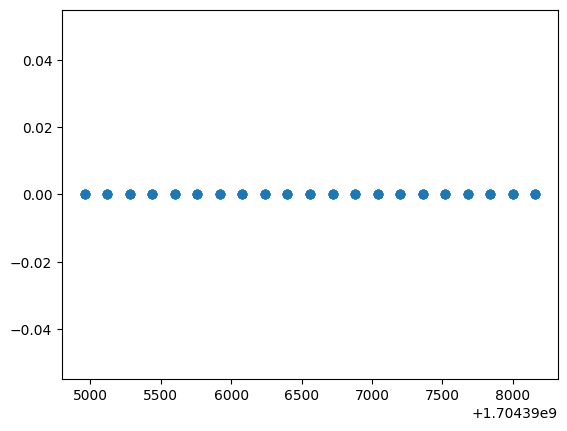

In [263]:
plt.scatter(hist.index, [0] * len(hist.index))